In [466]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
import heapq
import pandas as pd
from itertools import count

from Cube import Cube
from PointCloudDataFrame import PointCloudDataFrame

In [467]:
fix = pd.read_csv('model/model1.csv', index_col='label')

In [468]:
theta = np.random.rand(3)
print(theta)
offset = np.random.rand(3)
print(offset)

mov = fix.sample(frac=1, random_state=1)
correct_labels = mov.index
mov = Rotation.from_rotvec(theta).apply(mov) + offset
mov += (np.random.rand(*mov.shape)-0.5)/100
mov = pd.DataFrame(mov, columns=['x', 'y', 'z'])

[0.14881562 0.40833769 0.85485582]
[0.09748274 0.60927136 0.85378276]


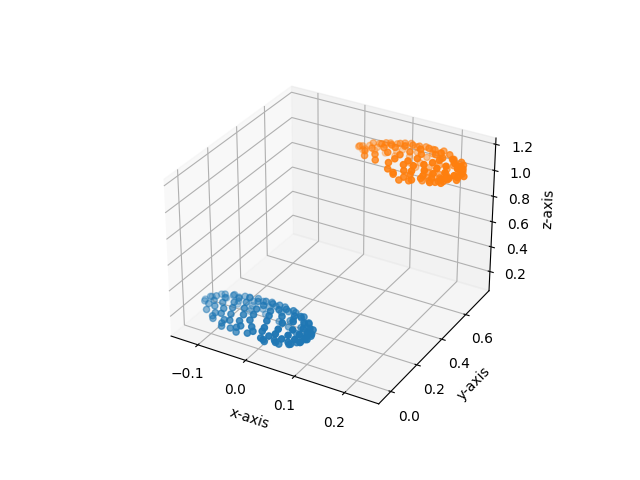

In [469]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov['x'], mov['y'], mov['z'])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [470]:
def tivs(array: np.ndarray):
    l = list()
    for i1, row1 in enumerate(array):
        for i2, row2 in enumerate(array):
            if i1 != i2:
                l.append(row1-row2)
    return np.array(l)

In [472]:
def get_largest_sample(array: np.ndarray, ratio: float, sample: int):
    norm = np.linalg.norm(array, axis=1)  # Get magnitudes of vectors
    a = np.concatenate((array, norm.reshape(-1,1)), axis=1)  # Add magnitudes to array
    a = a[a[:,3].argsort(), :3]  # Sort by size and remove magnitudes
    a = a[-int(a.shape[0] * ratio):]  # Select largest vectors
    a = np.random.permutation(a)[:sample]  # Get random sample of largest vectors
    return a

In [473]:
M = get_largest_sample(tivs(mov.to_numpy()), 0.05, 200)
S = get_largest_sample(tivs(fix.to_numpy()), 0.05, 200)

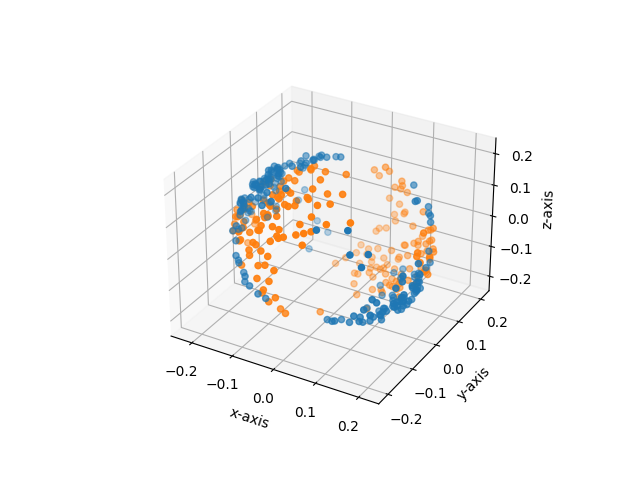

In [474]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(S[:,0], S[:,1], S[:,2])
ax.scatter(M[:,0], M[:,1], M[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [475]:
def q_func(moving, fixed, eps):
    return sum(1 - np.clip(np.min(cdist(moving, fixed), axis=1)/eps, 0, 1)**2)

In [476]:
def q_upper_func(moving, fixed, eps, cube: Cube):
    alpha = np.linalg.norm(cube.max - cube.min)/2
    delta = np.sqrt(2 * np.linalg.norm(moving, axis=1)**2 * (1 - np.cos(alpha)))
    return sum(1 - np.clip((np.min(cdist(moving, fixed), axis=1) - delta)/eps, 0, 1)**2)

In [477]:
def rotation_search(M: np.ndarray, S: np.ndarray):
    eps = 0.025
    q_max = 0
    c = Cube([-np.pi, -np.pi, -np.pi], [np.pi, np.pi, np.pi])
    r_opt = Rotation.from_rotvec(c.mid)
    gap = M.shape[0] * 0.25

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        r_c = Rotation.from_rotvec(c.mid)
        q_actual = q_func(r_c.apply(M), S, eps)
        if q_actual > q_max:
            q_max = q_actual
            r_opt = r_c
            print(r_opt.as_rotvec(), q_max, q_upper)

        for sub_c in c.subdivide():
            r_c = Rotation.from_rotvec(sub_c.mid)
            q_upper = q_upper_func(r_c.apply(M), S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return r_opt, q_max

In [478]:
r_opt, q_max = rotation_search(M, S)
print(r_opt.as_rotvec(), q_max)

[0. 0. 0.] 28.341017266399195 200.0
[-1.57079633 -1.57079633  1.57079633] 58.751769620197926 200.0
[ 1.57079633 -1.57079633  1.57079633] 74.38815887120496 200.0
[1.27140424 1.27140424 1.27140424] 75.37311990279206 200.0
[ 1.96819021  0.6560634  -1.96819021] 87.14167396479577 200.0
[ 1.67149361 -0.2387848   1.67149361] 88.48054760190284 200.0
[ 2.07879073 -1.48485052  0.89091031] 91.48947829563544 200.0
[ 1.96349541 -1.17809725  1.17809725] 92.81242226001145 200.0
[-0.9817477   2.55254403  0.19634954] 93.23742263981399 199.99567788670254
[-0.9817477   2.55254403 -0.19634954] 93.55499367554683 199.94166065604622
[-0.19634954 -0.58904862 -0.9817477 ] 96.05005152791207 199.7312874151631
[-0.29452431 -0.29452431 -0.88357293] 97.69687589312538 194.66334155223865
[-0.29452431 -0.49087385 -0.88357293] 99.38578116727335 194.17576737237474
[-0.88357293  2.6507188  -0.09817477] 102.23675152579098 193.09229153370296
[-0.04908739 -0.44178647 -0.83448555] 103.63494861321898 176.95543965712255
[-0.04

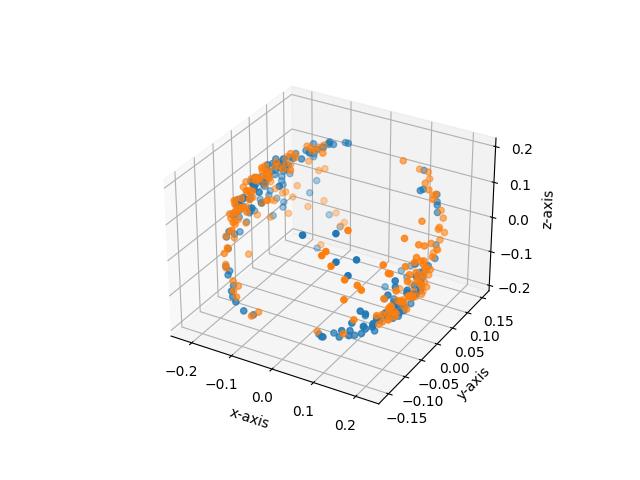

In [479]:
M2 = r_opt.apply(M)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(S[:,0], S[:,1], S[:,2])
ax.scatter(M2[:,0], M2[:,1], M2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

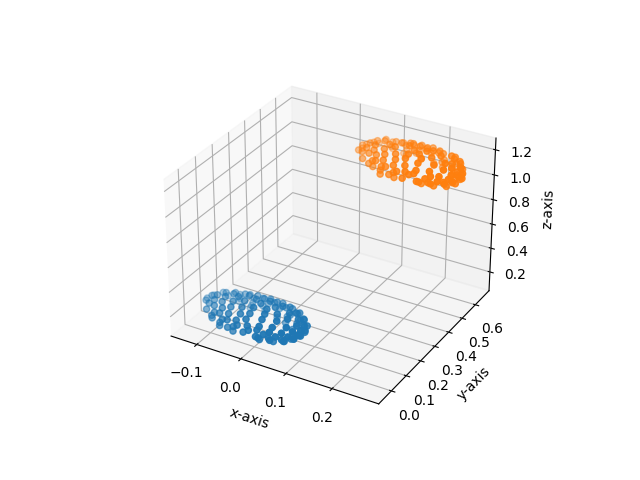

In [480]:
mov2 = r_opt.apply(mov)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov2[:,0], mov2[:,1], mov2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [523]:
def translation_search(M: np.ndarray, S: np.ndarray):
    eps = 1
    q_max = 0
    c = Cube(np.min(S, axis=0) - np.max(M, axis=0), np.max(S, axis=0) - np.min(M, axis=0))
    t_opt = c.mid
    gap = M.shape[0] * 0.01

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        t_c = c.mid
        q_actual = q_func(M + t_c, S, eps)
        if q_actual > q_max:
            q_max = q_actual
            t_opt = t_c
            print(t_c, q_actual)

        for sub_c in c.subdivide():
            t_c = sub_c.mid
            q_upper = q_upper_func(M + t_c, S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return t_opt, q_max

In [524]:
t_opt, q_max = translation_search(r_opt.apply(mov), fix)
print(t_opt, q_max)

[-0.1774439  -0.50939881 -0.89592259] 125.98598368359175
[-0.1774439  -0.50939881 -0.89592259] 125.98598368359175


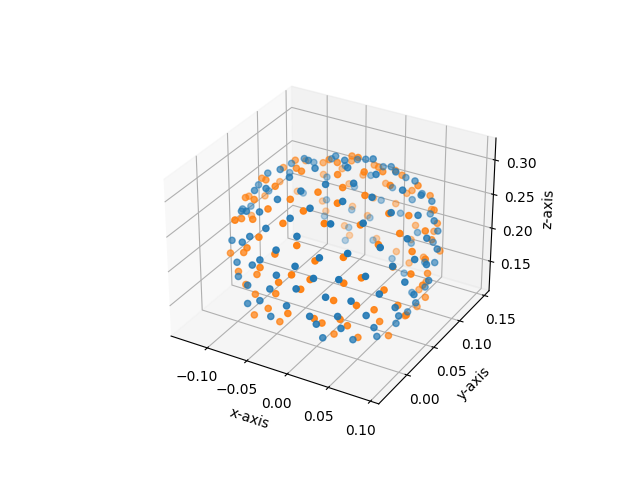

In [506]:
mov3 = r_opt.apply(mov) + t_opt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov3[:,0], mov3[:,1], mov3[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [492]:
mov.reset_index(drop=True, inplace=True)
temp_distances = cdist(r_opt.apply(mov) + t_opt, fix)
mov['label'] = ''

# For each point in the moving cloud...
for i in range(mov.shape[0]):
    # Find the pair of points with the smallest distance
    ind = np.unravel_index(np.argmin(temp_distances), temp_distances.shape)
    # Assigning distance to infinity essentially removes these points from consideration
    temp_distances[ind[0],:] = np.inf
    temp_distances[:,ind[1]] = np.inf

    # Assign the label
    mov.loc[ind[0], 'label'] = fix.index[ind[1]]

mov.set_index('label', drop=True, inplace=True)
print((mov.index == correct_labels).sum(), ':', mov.shape[0])

120 : 126
